In [1]:
!pip install transformers tokenizers datasets huggingface_hub --quiet

import numpy as np
import random
import os
import tensorflow as tf
from transformers import set_seed

rand_seed = 9

def seed_everything(seed=0):
    random.seed(seed) # random
    os.environ['PYTHONHASHSEED'] = str(seed) # python enviroment
    np.random.seed(seed) # numpy
    tf.keras.utils.set_random_seed(seed) # tensorflow
    tf.random.set_seed(seed) # tensorflow
    set_seed(seed) # hugging_face transformer

seed_everything(rand_seed)

###               --  0  --                       --  1  --                         --  2  --                    --  3  --
model_id = ['raygx/Nepali-DistilGPT2','raygx/Covid-News-Headline-Generator','raygx/Nepali-GPT2-CausalLM','Sakonii/distilgpt2-nepali'][0]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.1 MB/s eta 0:00:00


In [2]:
# from huggingface_hub import notebook_login
# notebook_login()

# Loading Model and Tokenizer

In [3]:
from transformers import TFAutoModelForSequenceClassification, PreTrainedTokenizerFast
import datasets

tokenizer = PreTrainedTokenizerFast.from_pretrained(model_id)
tokenizer

PreTrainedTokenizerFast(name_or_path='raygx/Nepali-DistilGPT2', vocab_size=50000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'pad_token': '[PAD]'}, clean_up_tokenization_spaces=True)

In [4]:
from transformers import AutoConfig
from transformers import BertTokenizerFast


config = AutoConfig.from_pretrained(
          model_id,
          bos_token_id=tokenizer.bos_token_id,
          eos_token_id=tokenizer.eos_token_id,
          pad_token_id=tokenizer.pad_token_id,
          id2label={0:"NEUTRAL",1:"POSITIVE",2:"NEGATIVE"},
          label2id={"NEUTRAL":0,"POSITIVE":1,"NEGATIVE":2}
        )


print("Intialization: Pretrained - {}".format(model_id))
model = TFAutoModelForSequenceClassification.from_pretrained(model_id,config = config)

model.resize_token_embeddings(len(tokenizer))

Intialization: Pretrained - raygx/Nepali-DistilGPT2


All model checkpoint layers were used when initializing TFGPT2ForSequenceClassification.

Some layers of TFGPT2ForSequenceClassification were not initialized from the model checkpoint at raygx/Nepali-DistilGPT2 and are newly initialized: ['score']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
print(model.config)
print(model.summary())

GPT2Config {
  "_name_or_path": "raygx/Nepali-DistilGPT2",
  "_num_labels": 1,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 1,
  "embd_pdrop": 0.1,
  "eos_token_id": 2,
  "id2label": {
    "0": "NEUTRAL",
    "1": "POSITIVE",
    "2": "NEGATIVE"
  },
  "initializer_range": 0.02,
  "label2id": {
    "NEGATIVE": 2,
    "NEUTRAL": 0,
    "POSITIVE": 1
  },
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 6,
  "n_inner": null,
  "n_layer": 6,
  "n_positions": 1024,
  "pad_token_id": 3,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length

In [6]:
# print(tokenizer("Hello World!",return_tensors='tf'))#, tokenizer.decode(tokenizer("Hello World!",return_tensors='tf')['input_ids']))
# model.transformer(tokenizer("Hello World!",return_tensors='tf'))

In [7]:
from transformers import create_optimizer, AdamWeightDecay
import tensorflow as tf

optimizer = AdamWeightDecay(learning_rate=1e-6, weight_decay_rate=0.01)
model.compile(optimizer=optimizer)

# Data Loading and Preparation

In [8]:
if False:
  print("#######################Using NepCov19Tweets#########################")
  data = datasets.load_dataset("raygx/NepCov19Tweets")
else:
  print("####################Using NepCov19TweetsPlus########################")
  data = datasets.load_dataset("raygx/NepCov19TweetsPlus")
# else:
#   print("####################Using NepCov19TweetsPlus2########################")
#   data = datasets.load_dataset("raygx/NepCov19TweetsPlus2")

data = data.rename_columns({"Sentiment":"label","Sentences":"text"})
data

####################Using NepCov19TweetsPlus########################


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/41541 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/raygx___parquet/raygx--NepCov19TweetsPlus-46f98dd56864ead2/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 41541
    })
})

In [10]:
### Data combination
# ar_d = datasets.load_dataset("raygx/CORONA_arabic2np")
en_d = datasets.load_dataset("raygx/CORONA_en2np")
en_d = en_d.rename_columns({"Sentiment":"label","Sentences":"text"})

print(en_d)
data['train'] = datasets.concatenate_datasets([data['train'],en_d['train']])

  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 5755
    })
})


In [11]:
data = data.shuffle(rand_seed)
data = data['train'].train_test_split(test_size=0.2)
data

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 37836
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 9460
    })
})

In [12]:
def prepareLabels(row):
    if int(row['label']) == -1:
        row['label'] = 2
    else:
      row['label'] = int(row['label'])

    return row

data = data.map(
        prepareLabels,
        num_proc=4)

print(data)

Map (num_proc=4):   0%|          | 0/37836 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/9460 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 37836
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 9460
    })
})


In [13]:
%%time

def preprocess_function(rows):
    return tokenizer(rows['text'],truncation=True)

print("Tokenizing the data")
tokenized_inputs = data.map(
    preprocess_function,
    batched=True,
    num_proc=2,
    remove_columns=data["train"].column_names,
)
# tokenized_inputs = tokenized_inputs.remove_columns(['token_type_ids'])

tokenized_inputs['train'] = tokenized_inputs['train'].add_column(
    name="label",column=data['train']['label']
)
tokenized_inputs['test'] = tokenized_inputs['test'].add_column(
    name="label",column=data['test']['label']
)

tokenized_inputs

Tokenizing the data


Map (num_proc=2):   0%|          | 0/37836 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map (num_proc=2):   0%|          | 0/9460 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


CPU times: user 621 ms, sys: 232 ms, total: 854 ms
Wall time: 12.4 s


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
        num_rows: 37836
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
        num_rows: 9460
    })
})

In [14]:
print(data['train'][:1])
print(tokenized_inputs['train'][:1]['input_ids'])
print(tokenizer.batch_decode(tokenized_inputs['train'][:1]['input_ids']))

{'label': [2], 'text': ['भारतीय कोभिड सबैभन्दा खतरनाक नि भनेथे क्यारे सर्वज्ञानी पर्धानले ती भारतीय झण्डाधारी भाइरसका बारे नि स्थाइ समितिको बैठकमा छलफल गरे त हुक्केहरुले हुक्केहरूका राजा त पर्धान हुन् क्यारे जनता त भुसुना भैहाले के कुरा गर्नु जाबा भुसुनाको सुख दु खको']}
[[1257, 1752, 1444, 11075, 289, 338, 1368, 14352, 1125, 29490, 522, 387, 256, 593, 1257, 7840, 6581, 46155, 4195, 289, 951, 186, 2528, 2746, 1447, 594, 85, 282, 49360, 717, 282, 49360, 2424, 1669, 85, 522, 387, 649, 14352, 1094, 85, 45368, 267, 1950, 5475, 345, 553, 785, 518, 306, 45368, 1937, 2764, 401, 38911]]
['भारतीय कोभिड सबैभन्दा खतरनाक नि भनेथे क्यारे सर्वज्ञानी पर्धानले ती भारतीय झण्डाधारी भाइरसका बारे नि स्थाइ समितिको बैठकमा छलफल गरे त हुक्केहरुले हुक्केहरूका राजा त पर्धान हुन् क्यारे जनता त भुसुना भैहाले के कुरा गर्नु जाबा भुसुनाको सुख दु खको']


In [15]:
from transformers import DataCollatorWithPadding

print("Initializing Data Collator")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer,
                                        max_length=128,
                                        return_tensors="tf")

Initializing Data Collator


In [16]:
print("Preparing Training and Testing sets to TRAIN the MODEL")
tf_train_set = model.prepare_tf_dataset(
    tokenized_inputs["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_test_set = model.prepare_tf_dataset(
    tokenized_inputs["test"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Preparing Training and Testing sets to TRAIN the MODEL


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2395: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


# Training and Evaluation

## Training **Batch 1**

In [26]:
%%time

n_epoch = 4
print("Training the model")
history = model.fit(x=tf_train_set,
          validation_data=tf_test_set,
          epochs=n_epoch)
print(history.history)

Training the model
Epoch 1/4
   1/2364 [..............................] - ETA: 7:07 - loss: 0.5653

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2395: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


2364/2364 [==============================] - 310s 131ms/step - loss: 0.6986 - val_loss: 0.6898
Epoch 2/4
2364/2364 [==============================] - 314s 133ms/step - loss: 0.6830 - val_loss: 0.6808
Epoch 3/4
2364/2364 [==============================] - 313s 133ms/step - loss: 0.6697 - val_loss: 0.6715
Epoch 4/4
2364/2364 [==============================] - 313s 132ms/step - loss: 0.6585 - val_loss: 0.6692
{'loss': [0.6985664963722229, 0.683006763458252, 0.669651210308075, 0.6585208773612976], 'val_loss': [0.6898297667503357, 0.6808094382286072, 0.6714938282966614, 0.6692155003547668]}
CPU times: user 17min 18s, sys: 32.3 s, total: 17min 51s
Wall time: 20min 58s


<Axes: >

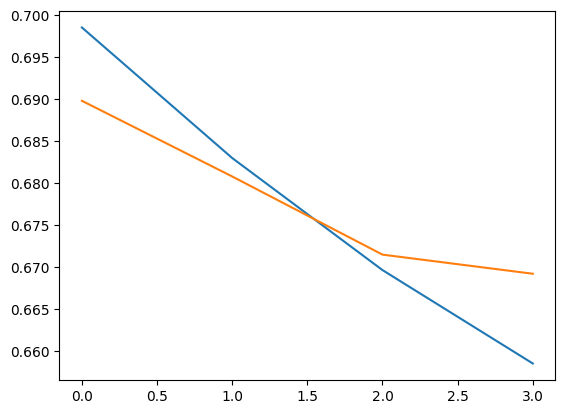

In [27]:
import seaborn

seaborn.lineplot(history.history['loss'])
seaborn.lineplot(history.history['val_loss'])

### Evaluation

In [28]:
%%time
from tqdm import tqdm
from transformers import pipeline

print("Getting Test Prediction")
pipe = pipeline('sentiment-analysis',model=model,tokenizer=tokenizer,device=1)
prediction = []

for x in tqdm(pipe(data['test']['text'])):
  prediction.append(model.config.label2id[x['label']])

actual_labels = data['test']['label']

Getting Test Prediction



100%|██████████| 9460/9460 [00:00<00:00, 768836.53it/s]

CPU times: user 16min 35s, sys: 8.36 s, total: 16min 44s
Wall time: 16min 37s


**Computing F1-Score, Precision, Recall and Accuracy of the Model**

In [29]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

print("F1-Score",f1_score(actual_labels,prediction,average='weighted'))
print("Precision-Score",precision_score(actual_labels,prediction,average='weighted'))
print("Recall-Score",recall_score(actual_labels,prediction,average='weighted'))
print("accuracy_Score",accuracy_score(actual_labels,prediction))

F1-Score 0.7205617035804356
Precision-Score 0.7370767024080899
Recall-Score 0.720507399577167
accuracy_Score 0.720507399577167


**Plotting Confusion Matrix**

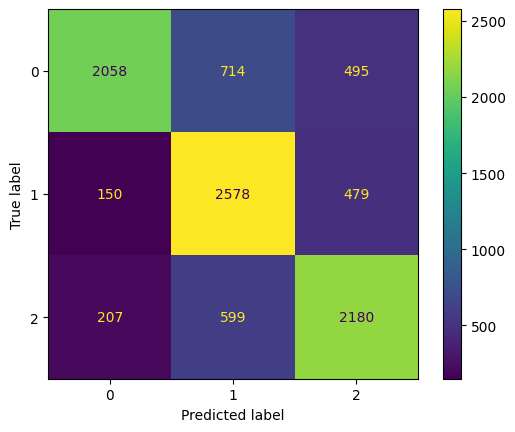

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cmd = ConfusionMatrixDisplay(tf.math.confusion_matrix(actual_labels,prediction,num_classes=3).numpy())
cmd.plot()